<a href="https://colab.research.google.com/github/CharlottePrimiceri/VP_Project/blob/main/Optical_flow/lucas_kanade_optical_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lucas-Kanade OPTICAL FLOW algorithm**

In [1]:
!pip install torch --quiet

In [2]:
! pip install torchvision --quiet

In [3]:
! pip install scikit-image --quiet

In [4]:
! pip install opencv-python --quiet

In [5]:
! pip install Pillow

In [6]:
! pip install tensorboardX --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.1 MB/s eta 0:00:00


In [7]:
import numpy as np
import random
import torch
import scipy
from sklearn.feature_extraction import image
import skimage
import PIL
import os
import torchvision
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt
from numpy import asarray
import math

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 1000, 2000])
torch.Size([3, 1000, 2000])


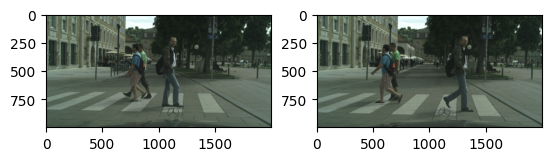

In [ ]:
# images to test the optical flow algorithm

transform = transforms.Compose([transforms.PILToTensor(), transforms.Resize([1000,2000])])

img1 = Image.open('/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02/stuttgart_02_000000_005838_leftImg8bit.png')
img1 = transform(img1)
print(img1.shape)

img2 = Image.open('/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02/stuttgart_02_000000_005845_leftImg8bit.png')
img2 = transform(img2)
print(img2.shape)

plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(img2.permute(1, 2, 0))


###Lucas-Kanade Algorithm

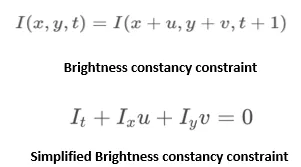

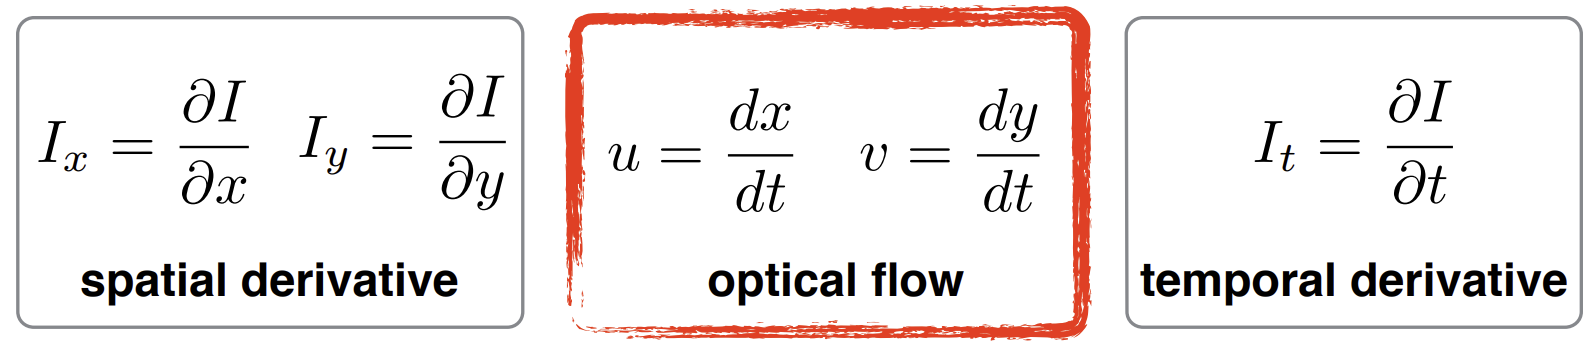

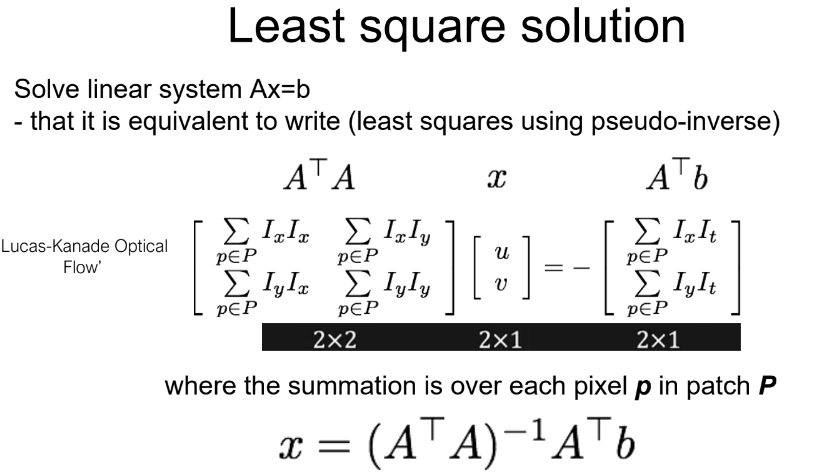

In [ ]:
def divide_into_patches(img):

    # adapt patch number to image shape

    img = img.numpy()
    print("Image shape: ", img.shape)
    dim_patch = 8
    print("Patch shape: ", dim_patch)
    num_patches = (img.shape[1] / dim_patch) * (img.shape[2] / dim_patch)
    print("Number of patches: ", int(num_patches))
    patches = skimage.util.view_as_blocks(img, (3, dim_patch, dim_patch))
    patches = torch.from_numpy(patches)
    print("Patched image tensor shape: ", patches.shape)

    return patches

In [ ]:
def optical_flow_lucas_kanade(img_a, img_b):

    # Lucas-Kanade hypothesis: constant flow in image patches

    # img gradient computation applying the Sobel filter:
    sobel_filter_horizontal = torch.Tensor([[[1, 0, -1], [2, 0, -2], [1, 0, -1]]])
    sobel_filter_vertical = torch.Tensor([[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]])
    Sx = sobel_filter_horizontal.repeat(3,1,1) # 3x3x3 kernel for 2D convolution
    Sy = sobel_filter_vertical.repeat(3,1,1)

    # x image gradient with Sobel filter
    Ix = scipy.signal.convolve(img_a, Sx, mode = 'same')
    Ix = torch.from_numpy(Ix)
    plt.subplot(2,3,1)
    plt.title("Horizontal image gradient:", fontsize=8)
    plt.imshow(Ix.permute(1, 2, 0))

    Ix_patched = divide_into_patches(Ix)

    # y image gradient with Sobel filter
    Iy = scipy.signal.convolve(img_a, Sy, mode = 'same')
    Iy= torch.from_numpy(Iy)
    plt.subplot(2,3,2)
    plt.title("Vertical image gradient:", fontsize=8)
    plt.imshow(Iy.permute(1, 2, 0))

    Iy_patched = divide_into_patches(Iy)

    # temporal gradient (pixel-by-pixel difference between consecutive frames)
    It = np.subtract(img_a, img_b)
    plt.subplot(2,3,3)
    plt.title("Time image gradient:", fontsize=8)
    plt.imshow(It.permute(1, 2, 0))

    It_patched = divide_into_patches(It).type(torch.FloatTensor)
    dim_patch = 8
    num_patches = (img_a.shape[1] / dim_patch) * (img_a.shape[2] / dim_patch)
    optical_flow_patched = torch.zeros((1,125,250,2,1))
    magnitude_opt_flow_patched = torch.zeros((1,125,250,1))
    orientation_opt_flow_patched = torch.zeros((1,125,250,1))
    for n in range(250):
        for m in range(125):
            Ix_patch = Ix_patched[0][m][n]
            Iy_patch = Iy_patched[0][m][n]
            It_patch = It_patched[0][m][n]
            c_11 = torch.sum(torch.square(Ix_patch))
            c_12 = torch.sum(torch.mul(Ix_patch, Iy_patch))
            c_21 = c_12
            c_22 = torch.sum(torch.square(Iy_patch))
            covariance_mat = torch.tensor([[c_11, c_12], [c_21, c_22]])
            v_1 = torch.sum(torch.mul(Ix_patch, It_patch))
            v_2 = torch.sum(torch.mul(Ix_patch, It_patch))
            vector = torch.tensor([[v_1], [v_2]])
            estimated_opt_flow_patch = torch.matmul(torch.inverse(covariance_mat), vector)
            optical_flow_patched[0][m][n] = estimated_opt_flow_patch
            magnitude_opt_flow_patched[0][m][n] = torch.norm(estimated_opt_flow_patch)
            orientation_opt_flow_patched[0][m][n] = torch.atan(estimated_opt_flow_patch[1]/estimated_opt_flow_patch[0])

    return optical_flow_patched, magnitude_opt_flow_patched, orientation_opt_flow_patched

# Show the optical flow with arrows on images

In [ ]:
# optical_flow_patched.shape = 1 x 125 x 250 x 2 x 1
# magnitude_opt_flow_patched = 1 x 125 x 250 x 1
# orientation_opt_flow_patched = 1 x 125 x 250 x 1

def arrows_parameters(optical_flow_patched, magnitude_opt_flow_patched, orientation_opt_flow_patched):

    scale = 1
    y_coord = np.arange(4, 126, 4).tolist()
    x_coord = np.arange(4, 251, 4).tolist()
    i, m, n = 0, 0, 0
    for x in x_coord:   # move column by column through all the patches in the image
      for y in y_coord:
        x1 = x
        y1 = y
        x2 = x + (magnitude_opt_flow_patched[0][m][n]*scale*math.cos(orientation_opt_flow_patched[0][m][n]))[0]
        y2 = y + (magnitude_opt_flow_patched[0][m][n]*scale*math.sin(orientation_opt_flow_patched[0][m][n]))[0]
        new_coord = np.array([[x1,y1,x2,y2]])
        if i==0:
          p_list = np.array([[x1,y1,x2,y2]])
        else:
          p_list = np.concatenate((p_list, new_coord), axis=0)
        i += 1
      n+=1
    m+=1

    return(p_list)


Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])


Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])
Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])


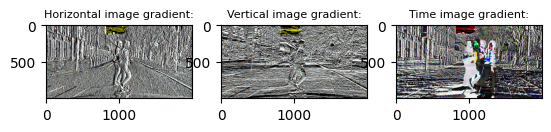

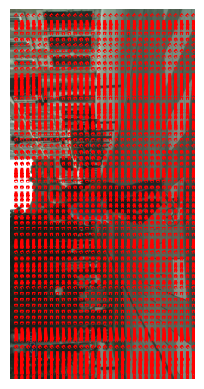

Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])


Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])
Image shape:  (3, 1000, 2000)
Patch shape:  8
Number of patches:  31250
Patched image tensor shape:  torch.Size([1, 125, 250, 3, 8, 8])


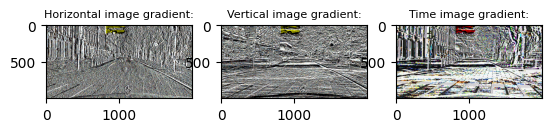

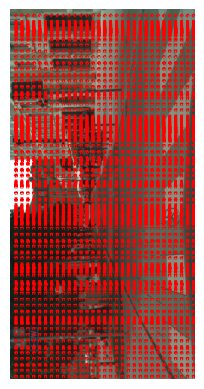

In [ ]:
img_dir = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02_short/"
transform = transforms.Compose([transforms.PILToTensor(), transforms.Resize([1000,2000])])

img_path_list = []

a = 0
for img_file in os.listdir(img_dir):
  if a % 5 ==0:
    img_path = os.path.join(img_dir, img_file)
    img_path_list.append(img_path)
  a += 1

i=0
for i in range(len(img_path_list)):
  if i % 10 == 0:
    img1_path = img_path_list[i]
    img2_path = img_path_list[i+1]
    img1 = Image.open(img1_path)
    img1 = transform(img1)
    img2 = Image.open(img2_path)
    img2 = transform(img2)

    opt_flow = optical_flow_lucas_kanade(img1,img2)

    coords = arrows_parameters(opt_flow[0], opt_flow[1], opt_flow[2])

    plt.figure("Optical flow vectors")
    plt.plot()
    plt.axis('off')
    for p in coords:
      plt.arrow(p[1]*8, p[0]*8, p[3]*8-p[1]*8, p[2]*8-p[0]*8, color='red', fill=False, linewidth = 2)
    img1 = img1.numpy()
    img1 = np.swapaxes(img1, 2, 0)
    plt.imshow(img1)
    plt.show()

    i += 1